> Code to accompany **Chapter 10: Defending Against Adversarial Inputs**

# Evaluating an Adversarially trained model

In this notebook, we'll take a look at how to evaluate the effectiveness of adversarial training as a defense.

A Fashion-MNIST classifier model that has been trained with adversarial data exists in `../models/fashionMNIST_advtrain_fastgradient.h5`. The training data used to generate this model was the original training data augmented with adversarial examples generated using the `foolbox.attacks.GradientSignAttack` attack.

If you would like to train your own model (perhaps with data generated using a 
different attack), take a look at [chapter10/fashionMNIST_adversarial_training.ipynb]().


## Load Dependencies and Helper utilities

Import the relevant modules.

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

Get the Fashion-MNIST data

In [12]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images/255.0
test_images = test_images/255.0

Import/define some helper utilities.

In [13]:
import sys
sys.path.append('..')
from strengtheningdnns.adversarial_utils import generate_adversarial_data

import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(model, test_images, expected_labels, class_names):
    predictions = model.predict(test_images)
    num_predictions = predictions.shape[0]
    pred_labels = np.zeros((num_predictions), dtype=int)
    for pred, index in zip(predictions, range(num_predictions)):
        pred_labels[index] = np.argmax(pred)
        
    # Create a confusion matrix on training data.
    with tf.Graph().as_default():
        cm = tf.confusion_matrix(labels=expected_labels, predictions=pred_labels, num_classes=len(class_names))
        with tf.Session() as session:
            cm_out = session.run(cm)

    # Normalize the confusion matrix so that each row sums to 1.
    cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_out, annot=True, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

## Load the original and adversarially trained models

In [14]:
model = tf.keras.models.load_model('../models/fashionMNIST.h5')
model_adv = tf.keras.models.load_model('../models/fashionMNIST_advtrain_fastgradient.h5')

## Compare the accuracy of the models

We'll begin by comparing the accuracy of each of the modelsagainst the non-adversarial (original) test data. 

This is a check to see that training with additional adversarial data does not unacceptably reduce the model's accuracy.

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Original model accuracy based on non-adversarial test data:', test_acc)
test_loss, test_acc = model_adv.evaluate(test_images, test_labels)
print('Adversarially trained model accuracy based on non-adversarial test data:', test_acc)

10000/10000 [==============================] - 0s 42us/sample - loss: 0.3623 - acc: 0.8704
Original model accuracy based on non-adversarial test data: 0.8704
10000/10000 [==============================] - 0s 40us/sample - loss: 0.3555 - acc: 0.8707
Adversarially trained model accuracy based on non-adversarial test data: 0.8707


The accuracy of both models on the non-adversarial test data is similar.

## Evaluate the Defence - Assume Attacker has no Knowledge

We'll start by evaluating the defence assuming that the attacker has no knowledge of it. 

In [16]:
import foolbox
fmodel = foolbox.models.TensorFlowModel.from_keras(model, bounds=(0, 1))

In [17]:
attack_criterion = foolbox.criteria.Misclassification()
x_images = test_images[0:600, :]

Generate adversarial data using the original model

In [18]:
attack_fn = foolbox.attacks.GradientSignAttack(fmodel, criterion=attack_criterion, distance=foolbox.distances.Linfinity)
(x_test_adv_images1, x_test_adv_perturbs1, x_test_labels1) = generate_adversarial_data(original_images = x_images, 
                                                                                  predictions = model.predict(x_images), 
                                                                                  attack_fn = attack_fn)

Take a look at how well the adversarial examples work on the adversarially trained model

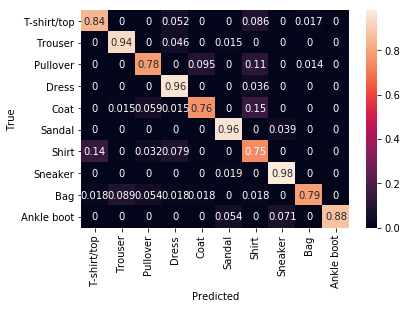

In [19]:
show_confusion_matrix(model_adv, x_test_adv_images1, x_test_labels1, class_names)

This looks really good. Almost all the adversarial test data has been correctly classified by the model.

Unfortunately this is a poor evaluation:

* Firstly, we’ve only tested the model’s robustness to a specific attack. You may want to test using another of the FoolBox attacks (or adversarial data generated through an attack in another library).

* Secondly, for a proper evaluation, we need to assume that the attacker has complete knowledge of the model and its defenses. An attacker with complete knowledge is able to generate their adversarial data directly against the adversarially trained model, so this is the scenario that needs to be evaluated.
 
To address the 2nd point, let’s regenerate the test data using the adversarially trained model.

## Evaluate the Defence - Assume Attacker has full Knowledge

Now let's do a better evaluation assuming complete knowledge of the defence by the attacker.

In this case, the attacker would use the adversarially trained model to create their attack data. We'll create some attack data using this model.

In [20]:
fmodel_adv = foolbox.models.TensorFlowModel.from_keras(model_adv, bounds=(0, 1))
attack_fn = foolbox.attacks.GradientSignAttack(fmodel_adv, criterion=attack_criterion, distance=foolbox.distances.Linfinity)
(x_test_adv_images2, x_test_adv_perturbs2, x_test_labels2) = generate_adversarial_data(original_images = x_images, 
                                                                                  predictions = model_adv.predict(x_images), 
                                                                                  attack_fn = attack_fn)

C:\Users\katyw\Anaconda3\envs\strengthening-dnns\lib\site-packages\foolbox\attacks\base.py:148: UserWarning: GradientSignAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))


Take a look at the confusion matrix...

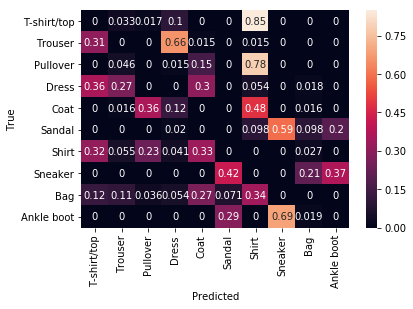

In [21]:
show_confusion_matrix(model_adv, x_test_adv_images2, x_test_labels2, class_names)

You can see that this time the model has performed far worse and has failed to classify any of the adversarial examples, despite it having been adversarially trained. We can conclude that this is a very poor defense against adversarial input.

Now let's take a look at whether it's more difficult for the adversary to create adversarial examples for the adversarially trained model. We'll plot success rate against required perturbation.

The helper method ++generate_adversarial_data++ returns distance measurements for each of the adversarial examples that were found. The ++GradientSign++ method optimises for the minimum distance, so these should indicate the minimum
distance required for each adversarial example.

Let's plot the perturbations required to generate adversarial examples against the original model and 
the adversarially trained model.


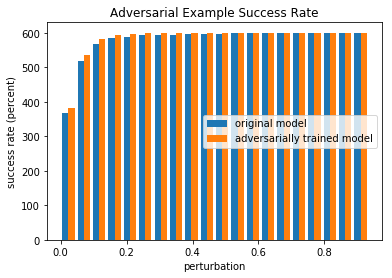

In [23]:
import matplotlib.pyplot as plt

plt.hist((x_test_adv_perturbs1['foolbox_diff'], 
          x_test_adv_perturbs2['foolbox_diff']), 
         bins=20, 
         cumulative=True,
         label=('original model','adversarially trained model'))

plt.title("Adversarial Example Success Rate")
plt.xlabel("perturbation")
plt.ylabel("success rate (percent)")
plt.legend(loc='right')

plt.show()

What a disappointment, they are almost exactly the same. So, it's no more difficult the generate adversarial 
examples on the adversarially trained model.

There are thousands of directions in which the image might be perturbed to create an adversarial example. The trained network as closed off some of these options, but there are many more still available to the algorithm. With extensive adversarial training, we might remove increasing numbers of options, but this is unlikely to cover every possibility open to the adversarial algorithm (although, it may take the algorithm a longer time to locate adversarial input).

## What next?

Take a look at a stronger defence in [../chapter10/fashionMNIST_dropout_for_detection.ipynb]()